# Manipulate LondonAir gridded (modelled) concentrations data to Census Zones

Part of [london-data](https://github.com/jamesdamillington/london-data), by [jamesdamillington](https://github.com/jamesdamillington)

## Aim
Summarise [LondonAir air quality data](https://data.london.gov.uk/air-quality/) from 20m grid to London Census Zones (LSOAs, MSOAs and Boroughs [LADs]). 

Inputs are `.asc` ESRI ASCII grid data for different pollutants. Outputs will be `.csv` with zone-by-row (e.g. LSOA-by-row) that can be readily joined to [ONS Geographies data](https://github.com/jamesdamillington/london-data/tree/main/data/geographies/census). 

In [1]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2023-11-24


In [2]:
import geopandas as gpd
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.colors as mpc

import numpy as np

import rasterio as rio
import rasterio.mask
from rasterio.plot import show
from rasterstats import zonal_stats

## Get Geography

Read geographies for regions to summarise grid onto:

[London 2011 LSOA census geography](https://github.com/jamesdamillington/london-data/tree/main/data/geographies/census) 

[Generalised (20m) LSOA geometries](https://geoportal.statistics.gov.uk/datasets/ons::lower-layer-super-output-areas-2021-boundaries-ew-bgc/explore) (clipped to the coastline) data downloaded [2023-08-15] as *Lower_layer_Super_Output_Areas_2021_EW_BGC_V3_7972316521517759310.zip*

> Source: Office for National Statistics licensed under the Open Government Licence v.3.0  
Contains OS data © Crown copyright and database right (2022)
Contains both Ordnance Survey and ONS Intellectual Property Rights.

MSOA and LAD shapefiles are 'dissolved' from the Generalised (20m) LSOA geometries (see [code here](https://github.com/jamesdamillington/london-data/blob/main/code/london-census2021-geography.ipynb))

In [4]:
census_path = Path("../data/geographies/census/")
lsoa11 = gpd.read_file(census_path/"london-2011-lsoa.shp")
lsoa11 = lsoa11.set_index(lsoa11.LSOA11CD)

lsoa21 = gpd.read_file(census_path/"london-2021-lsoa-gen20.shp")
lsoa21 = lsoa21.set_index(lsoa21.LSOA21CD)

moa21 = gpd.read_file(census_path/"london-2021-msoa-gen20.shp")
msoa21 = msoa21.set_index(msoa21.LSOA21CD)

lad21 = gpd.read_file(census_path/"london-2021-lad22-gen20.shp")
lad21 = lad21.set_index(lad21.LAD22CD)

## Data

Original data downloaded [2022-09-06] are:
- 2019 Concentrations - [Data](https://data.london.gov.uk/download/london-atmospheric-emissions-inventory--laei--2019/173ed1c2-26c4-4286-96d8-12da40a0c94f/LAEI2019-Concentrations-Data-ASCII.zip) - ASCII Files (.ZIP - 132.2 MB) _"This dataset includes modelled 2019 ground level concentrations of annual mean NOx, NO2, PM10 and PM2.5 in µg/m3 (microgramme per cubic metre) at 20m grid resolution. For PM10, it also includes the number of daily means exceeding 50 µg/m3."_ [source](https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory--laei--2019)
- 2016  Concentrations - [Data](https://data.london.gov.uk/download/london-atmospheric-emissions-inventory--laei--2016/924b02c9-bc9c-4fb4-b3aa-0783b9fd84e8/LAEI_2016_Concentrations_Data_ASCII.zip) - ASCII Files (.ZIP - 86.4MB) _"This dataset includes modelled 2016 ground level concentrations of annual mean NOx, NO2, PM10 and PM2.5 in µg/m3 (microgramme per cubic metre) at 20m grid resolution. For PM10, it also includes the number of daily means exceeding 50 µg/m3."_ [source](https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory--laei--2016)
- 2013 Concentrations - [Data](https://files.datapress.com/london/dataset/london-atmospheric-emissions-inventory-2013/2017-01-26T18:50:00/4.1.%20Concentrations%20LAEI%202013%20Update.zip) - LAEI 2013 Update  (.ZIP - 767.837 KB) - _"Modelled 2013 and 2020 concentrations of NO2, NOx, PM10, PM10d and PM2.5 at 20m grid level. 04/04/2017 - Please note this file contains updated revised LAEI 2013 concentration data which should now replace files previously provided for 2013 and 2020."_ [source](https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory-2013) (NB: data from 2013/ASCII/ folder within zip)

> Source: London Atmospheric Emissions Inventory (LAEI) licensed under the [Open Government Licence v.2.0](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/2/)  


In [5]:
aq_ipath = Path("../data/inputs/airquality/")

## Demo

In [6]:
pm25_19 = rio.open(aq_ipath/"laei_LAEI2019v3_CorNOx15_PM25.asc")

In [7]:
pm25_19.meta

{'driver': 'AAIGrid',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 3026,
 'height': 2555,
 'count': 1,
 'crs': None,
 'transform': Affine(20.0, 0.0, 501470.0,
        0.0, -20.0, 203450.0)}

Mask the no data values outside London

In [8]:
pm25_19_lon, pm25_19_lon_trans = rio.mask.mask(dataset=pm25_19, shapes=lsoa21.geometry, crop=True) 
pm25_19_lon[pm25_19_lon == -9999.0] = np.nan

Plot the frequency distribution (histogram) of the data

(array([3.931729e+06, 1.378000e+03, 2.900000e+01, 1.000000e+00,
        0.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([  8.810443,  19.711998,  30.613554,  41.51511 ,  52.416664,
         63.31822 ,  74.21977 ,  85.12133 ,  96.02289 , 106.92444 ,
        117.826   ], dtype=float32),
 <BarContainer object of 10 artists>)

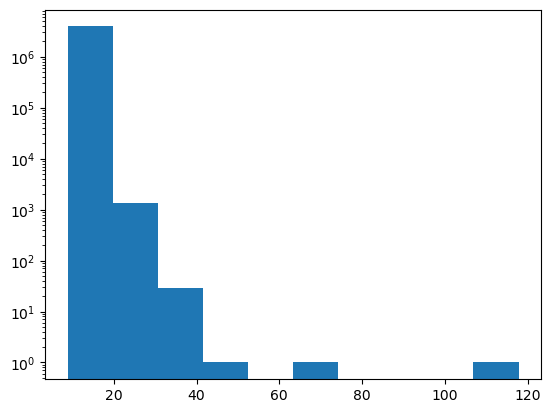

In [10]:
plt.hist(pm25_19_lon.flatten(),log=True)

Visually check spatial distribution (using log normalization on the colormap given the frequency distribution)

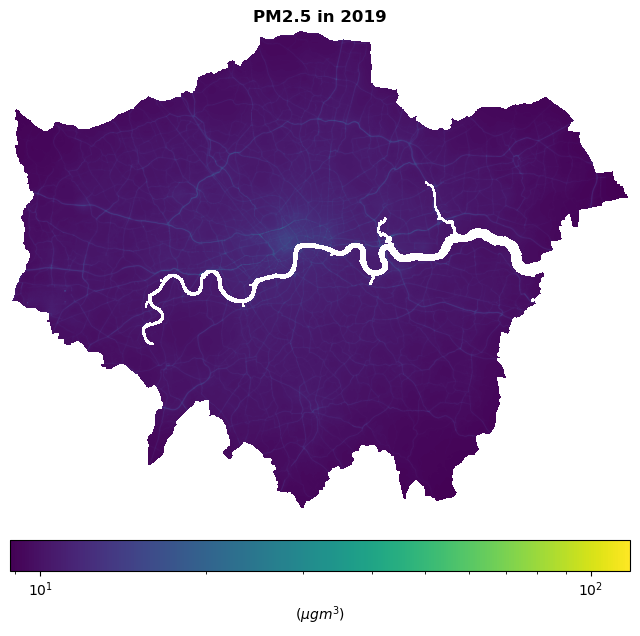

In [23]:
fig, axs = plt.subplots(1, figsize=(8,8))

#https://matplotlib.org/stable/users/explain/colors/colormapnorms.html
normDict={'norm':mpc.LogNorm()}

aqplot=show(pm25_19_lon[0], 
            transform=pm25_19_lon_trans, 
            ax=axs, 
            title=r"PM2.5 in 2019",  
            **normDict 
           ) 
axs.axis('off') #don't plot the axes (bounding box)
#plotting color bar from https://stackoverflow.com/a/70334691
im = aqplot.get_images()[0]
fig.colorbar(im, ax=axs,
             orientation='horizontal', 
             label=r"($\mu g m^{3}$)",
             pad=0.05)

plt.show()

Overlay zone boundaries for visualsation (zoom to help)

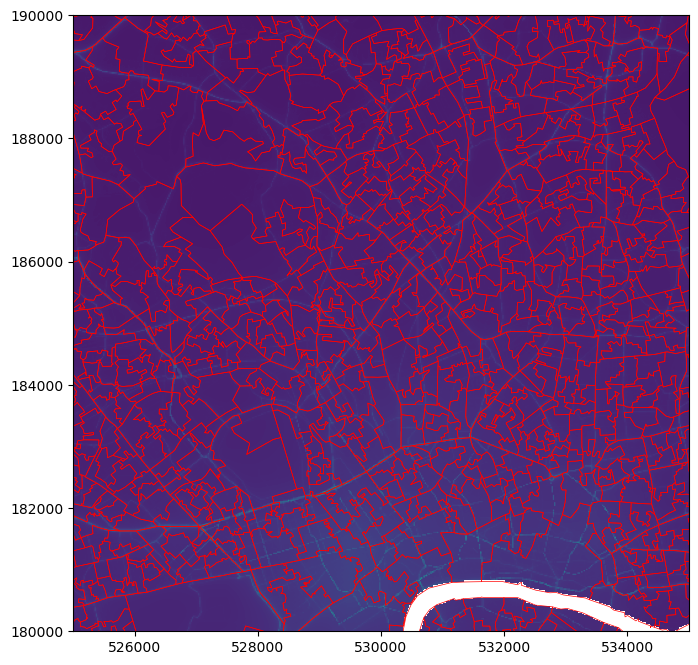

In [25]:
fig, axs = plt.subplots(1, figsize=(8,8))

#https://matplotlib.org/stable/users/explain/colors/colormapnorms.html
normDict={'norm':mpc.LogNorm()}

show(pm25_19_lon[0], transform=pm25_19_lon_trans, ax=axs, 
     **normDict
    ) 

lsoa21.plot(ax=axs, facecolor='None', edgecolor='red', linewidth=0.5)
axs.set_xlim(525000,535000)
axs.set_ylim(180000,190000)
plt.show()

Calculate zonal statistics (i.e summarise raster by polygon regions)

In [26]:
%%time
zs21_pm25_19 = zonal_stats(lsoa21, pm25_19.read(1),   #input 2d raster (dataset reader is 3D)
                           affine=pm25_19.meta['transform'],  
                           nodata=pm25_19.meta['nodata'],
                           stats=['min', 'max', 'mean', 'median', 'std'],
                           prefix="PM25_2019_")

CPU times: user 17.9 s, sys: 37.4 s, total: 55.3 s
Wall time: 1min 59s


In [27]:
zs21_pm25_19pd = pd.DataFrame(zs21_pm25_2019)   #convert dict to pandas df
zs21_pm25_19pd.set_index(lsoa21.index,inplace=True)   #set index for merge below

Merge and plot

<AxesSubplot:>

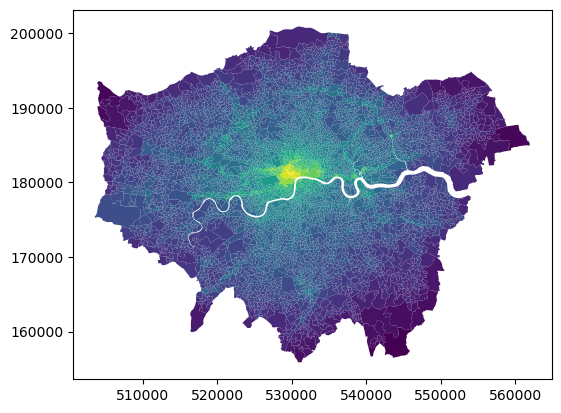

In [28]:
lsoa21_pm25_19 = lsoa21.merge(zs21_pm25_19pd, left_index=True, right_index=True)
lsoa21_pm25_19.plot('PM25_2019_mean')

Compare original raster to new zonal summaries

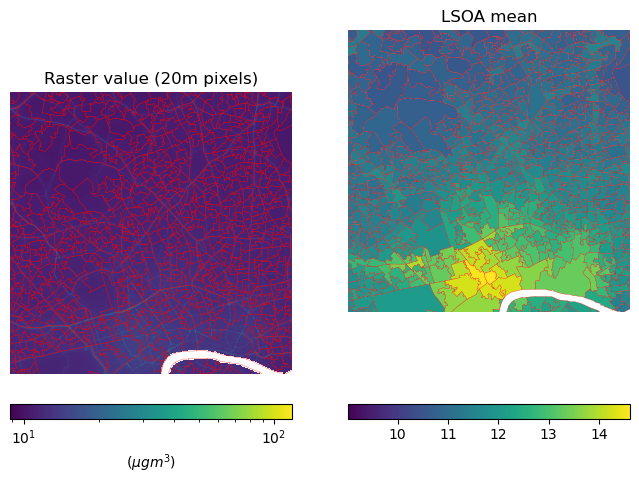

In [51]:
fig, axs = plt.subplots(1,2, figsize=(8,8))

#https://matplotlib.org/stable/users/explain/colors/colormapnorms.html
normDict={'norm':mpc.LogNorm()}

aqplot=show(pm25_19_lon[0], transform=pm25_19_lon_trans, ax=axs[0], 
     **normDict
    ) 

im = aqplot.get_images()[0]
fig.colorbar(im, ax=axs[0],
             orientation='horizontal', 
             label=r"($\mu g m^{3}$)",
             pad=0.05)
lsoa21.plot(ax=axs[0], facecolor='None', edgecolor='red', linewidth=0.2)
axs[0].set_title("Raster value (20m pixels)")

axs[0].axis('off')
axs[1].axis('off')
    
axs[1].set_title("LSOA mean")
lsoa21_pm25_19.plot('PM25_2019_mean', ax=axs[1], legend=True,
                   edgecolor='red', linewidth=0.2,
                    legend_kwds={'orientation':'horizontal'})

custom_xlim=(525000,535000)
custom_ylim=(180000,190000)

# Setting the values for all axes.
plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)
plt.show()

## Implementation

In [52]:
aq_opath = Path("../data/airquality/")

Function collapsing the demo code above for looping over multiple pollutants

In [53]:
def summarise_aq_raster(london_geo, rio_dr, label):
    print("Calculating zonal stats for " + label)
    zs_dict = zonal_stats(london_geo, rio_dr.read(1),    #input 2d raster (dataset reader is 3D)
                           affine=rio_dr.meta['transform'],
                           nodata=rio_dr.meta['nodata'],
                           stats=['min', 'max', 'mean', 'median', 'std'],
                           prefix=label)
    zs_pd = pd.DataFrame(zs_dict)
    zs_pd.set_index(london_geo.index,inplace=True)
    zs_pd=zs_pd.round(3)
    return zs_pd

In [54]:
#dict to use in loops below  (label:filename)
dict_2019 = {
    "PM25":"laei_LAEI2019v3_CorNOx15_PM25.asc",
    "PM10":"laei_LAEI2019v3_CorNOx15_PM10m.asc",
    "PM10d":"laei_LAEI2019v3_CorNOx15_PM10d.asc",
    "NOx":"laei_LAEI2019v3_CorNOx15_NOx.asc",
    "NO2":"laei_LAEI2019v3_CorNOx15_NO2.asc"
}

In [55]:
for k, v in dict_2019.items():
    rio_dr_2019 = rio.open(aq_ipath/"ASCII-2019"/v)
    pd2019 = summarise_aq_raster(lsoa21, rio_dr_2019, "{0}-2019-".format(k))
    pd2019.to_csv(aq_opath/"lsoa21-2019-{0}.csv".format(k))

Calculating zonal stats for PM25-2019-
Calculating zonal stats for PM10-2019-
Calculating zonal stats for PM10d-2019-
Calculating zonal stats for NOx-2019-
Calculating zonal stats for NO2-2019-


In [56]:
#dict to use in loops below  (label:filename)
dict_2016 = {
    "PM25":"LAEI2016_2016_PM25.asc",
    "PM10":"LAEI2016_2016_PM10.asc",
    "PM10d":"LAEI2016_2016_PM10d.asc",
    "NOx":"LAEI2016_2016_NOx.asc",
    "NO2":"LAEI2016_2016_NO2.asc"
}

In [57]:
for k, v in dict_2016.items():
    rio_dr_2016 = rio.open(aq_ipath/"ASCII-2016"/v)
    pd2016 = summarise_aq_raster(lsoa21, rio_dr_2016, "{0}-2016-".format(k))
    pd2016.to_csv(aq_opath/"lsoa21-2016-{0}.csv".format(k))

Calculating zonal stats for PM25-2016-
Calculating zonal stats for PM10-2016-
Calculating zonal stats for PM10d-2016-
Calculating zonal stats for NOx-2016-
Calculating zonal stats for NO2-2016-


In [58]:
#dict to use in loops below  (label:filename)
dict_2013 = {
    "PM25":"PostLAEI2013_2013_PM25.asc",
    "PM10":"PostLAEI2013_2013_PM10.asc",
    "PM10d":"PostLAEI2013_2013_PM10d.asc",
    "NOx":"PostLAEI2013_2013_NOx.asc",
    "NO2":"PostLAEI2013_2013_NO2.asc"
}

In [59]:
%%time
for k, v in dict_2013.items():
    rio_dr_2013 = rio.open(aq_ipath/"ASCII-2013"/v)
    pd2013 = summarise_aq_raster(lsoa21, rio_dr_2013, "{0}-2013-".format(k))
    pd2013.to_csv(aq_opath/"lsoa21-2013-{0}.csv".format(k))

Calculating zonal stats for PM25-2013-
Calculating zonal stats for PM10-2013-
Calculating zonal stats for PM10d-2013-
Calculating zonal stats for NOx-2013-
Calculating zonal stats for NO2-2013-
CPU times: user 1min 36s, sys: 4min 3s, total: 5min 40s
Wall time: 12min 9s
